1\. **Pandas DataFrame**

This exercise consists in analyzing a dataset containg timing information from a series of Time-to-Digital-Converters (TDC) implemented in a pair of FPGAs. Each measurement (i.e. each row of the input file) consists of a flag that specifies the type of message ('HEAD', which in this case is always 1), two addresses of the TDC providing the signal ('FPGA' and 'TDC_CHANNEL'), and the timing information ('ORBIT_CNT', 'BX_COUNTER', and 'TDC_MEAS'). Each TDC count corresponds to 25/30 ns, whereas a unit of BX_COUNTER corresponds to 25 ns, and the ORBIT_CNT is increased every `x` BX_COUNTER. This allows to store the time in a similar way to hours, minutes and seconds.

In [1]:
# If haven't downloaded it yet, please get the data file with wget
!wget https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt -P ./data/

--2022-12-02 20:01:50--  https://www.dropbox.com/s/xvjzaxzz3ysphme/data_000637.txt
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:6016:18::a27d:112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/xvjzaxzz3ysphme/data_000637.txt [following]
--2022-12-02 20:01:50--  https://www.dropbox.com/s/raw/xvjzaxzz3ysphme/data_000637.txt
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uccaf55d8030304f3ededf1cd014.dl.dropboxusercontent.com/cd/0/inline/Bx4p51hma_kmkq5XdfRlBUVeC6H4qZswoatiEBrHzMTJ8702rk73GqZZW8XIL31W_pDaaTW6wcKmUotY-QfB_tWliTvgX4fbXVMV14dAjnM8D9WqLeJBJWXRwBWXHptxjIR1SbRPjGGEoc5VOk1xM-_xy8B5MADgdiYHrlm1dIXUHg/file# [following]
--2022-12-02 20:01:51--  https://uccaf55d8030304f3ededf1cd014.dl.dropboxusercontent.com/cd/0/inline/Bx4p51hma_kmkq5XdfRlBUVeC6H4qZswoatiEBrHzMTJ8702rk73GqZZW8XIL31W_pDaaTW

1\. Create a Pandas DataFrame reading N rows of the `data/data_000637.txt` dataset. Choose N to be smaller than or equal to the maximum number of rows and larger that 10k (check the documentation).

In [2]:
import pandas as pd
import numpy as np

In [5]:
N = 15000
df = pd.read_csv("/content/data/data_000637.txt", sep=",")
df = df.iloc[:N, :]
df

,HEAD,FPGA,TDC_CHANNEL,ORBIT_CNT,BX_COUNTER,TDC_MEAS
0,1,0,123,3869200167,2374,26
1,1,0,124,3869200167,2374,27
2,1,0,63,3869200167,2553,28
3,1,0,64,3869200167,2558,19
4,1,0,64,3869200167,2760,25
...,...,...,...,...,...,...
14995,1,1,4,3869200316,3399,9
14996,1,1,17,3869200316,3400,15
14997,1,1,10,3869200316,3530,16
14998,1,1,8,3869200316,3533,18


2\. Estimate the number of BX in a ORBIT (the value `x`).

*Hint*: check when the BX counter reaches the maximum value before being reset to 0.

In [8]:
x = df[df['BX_COUNTER']==0].index[0] - 1
print(f"at the index No. {x}, BX counter reaches the maximum value before being reset to 0")

at the index No. 2893, BX counter reaches the maximum value before being reset to 0


3\. Create a new column with the absolute time in ns (as a combination of the other three columns with timing information) since the beginning of the data acquisition, and convert the new column to a Time Series.

In [18]:
df['ABS_TIME'] = 0.3*df['ORBIT_CNT'] + 25*(df['TDC_MEAS'])/30 + 25*df['BX_COUNTER']
ts = pd.to_datetime(df['ABS_TIME'], unit='s')
ts

0       2006-10-14 09:50:21.766666752
1       2006-10-14 09:50:22.600000000
2       2006-10-14 11:04:58.433333248
3       2006-10-14 11:06:55.933333248
4       2006-10-14 12:31:10.933333248
                     ...             
14995   2006-10-14 16:57:57.300000000
14996   2006-10-14 16:58:27.300000000
14997   2006-10-14 17:52:38.133333248
14998   2006-10-14 17:53:54.800000000
14999   2006-10-14 17:56:09.800000000
Name: ABS_TIME, Length: 15000, dtype: datetime64[ns]

4\. Find out the duration of the data taking in hours, minutes and seconds, by using the features of the Time Series. Perform this check reading the whole dataset.

In [28]:
dif = ts[14999]-ts[0]
sec = dif.seconds
minutes = sec / 60
hours = minutes / 60
print(f"hours: {hours:.2f}")
print(f"minutes: {minutes}")
print(f"seconds: {sec}")

hours: 8.10
minutes: 485.8
seconds: 29148


5\. Use the `.groupby()` method to find out the noisy channels, i.e. the TDC channels with most counts (print to screen the top 3 and the corresponding counts)

In [57]:
channels = df.groupby(['TDC_CHANNEL']).count()['ORBIT_CNT'].to_dict()
top_three = sorted(channels.items(), key=lambda item: item[1])[::-1][:3]
print(f"The most noisy channel: {top_three[0][0]}, counts: {top_three[0][1]}")
print(f"The second most noisy channel: {top_three[1][0]}, counts: {top_three[1][1]}")
print(f"The third most noisy channel: {top_three[2][0]}, counts: {top_three[2][1]}")

The most noisy channel: 139, counts: 1268
The second most noisy channel: 64, counts: 752
The third most noisy channel: 63, counts: 749


6\. Count the number of non-empty orbits (i.e. the number of orbits with at least one hit).

In [59]:
non_empty = df[df['BX_COUNTER']!=0].count()['BX_COUNTER']
non_empty

14993

7\. Count the number of unique orbits with at least one measurement from TDC_CHANNEL=139.

In [75]:
numbers = len(np.unique(df[(df['TDC_CHANNEL']==139) & (df['BX_COUNTER']!=0)]['ORBIT_CNT']))
print(numbers)

78


8\. Create two Series (one for each FPGA) that have the TDC channel as index, and the number of counts for the corresponding TDC channel as values.

In [83]:
data = df.groupby(["FPGA", "TDC_CHANNEL"]).count()['HEAD']
serie1 = data[0]
serie2 = data[1]
data

FPGA  TDC_CHANNEL
0     1                8
      2               16
      3               16
      4               19
      5               19
                    ... 
1     125              6
      126              7
      127             16
      128             18
      139            389
Name: HEAD, Length: 241, dtype: int64

9\. **Optional:** Create two histograms (one for each FPGA) that show the number of counts for each TDC channel.

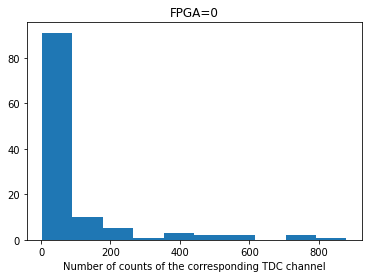

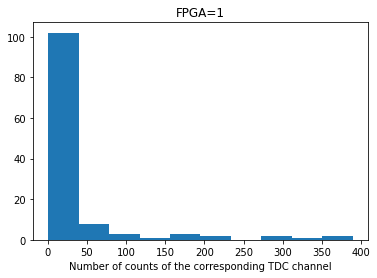

In [90]:
import matplotlib.pyplot as plt
plt.hist(serie1)
plt.title("FPGA=0")
plt.xlabel("Number of counts of the corresponding TDC channel")
plt.show()
plt.hist(serie2)
plt.title("FPGA=1")
plt.xlabel("Number of counts of the corresponding TDC channel")
plt.show()